In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import dsa
from dsa import *
from datasets import image
from models import resnet
import pickle

In [2]:
# limit tf to use the first gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the second GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


2022-02-25 05:33:21.131288: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-25 05:33:22.535370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10543 MB memory:  -> device: 1, name: TITAN V, pci bus id: 0000:5e:00.0, compute capability: 7.0


In [3]:
train_ds = tfds.load("cats_vs_dogs")
# test_ds  = tfds.load("celeb_a", split='train[80%:100%]')

In [4]:
x = [x["image"].numpy() for x in train_ds["train"]]
y = [x["label"].numpy() for x in train_ds["train"]]

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = np.array([tf.image.resize(i, size=(32,32)).numpy() for i in x_train])
x_test = np.array([tf.image.resize(i, size=(32,32)).numpy() for i in x_test])

def make_dataset(x, y, f):
    x = tf.data.Dataset.from_tensor_slices(x).map(f)
    y = tf.data.Dataset.from_tensor_slices(y)
    return tf.data.Dataset.zip((x, y)).shuffle(1000)

target_ds = make_dataset(x_train, y_train, lambda x: tf.clip_by_value(x/(255.0/2.0)-1.0, -1., 1.))
aux_ds = make_dataset(x_test, y_test, lambda x: tf.clip_by_value(x/(255.0/2.0)-1.0, -1., 1.))

In [22]:
cat_dog_dsa = {}
log = {}

for split in [2,3,4]:
    make_f, make_g, make_e, make_d, make_c = resnet.make_resnet(split=split, class_num=10)
    cat_dog_dsa["cat_vs_dog-split="+str(split)] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log["cat_vs_dog-split="+str(split)] = cat_dog_dsa["cat_vs_dog-split="+str(split)].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        batch_size=64,
        iterations=5000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.0001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.0001,
        lr_c=0.0001,
        iter_d=100,   # the number of iterations to train the decoder on auxiliary data
        w=500.,
        verbose=True,
        log_freq=100)

with open('log/cat_dog.pkl', 'wb') as f:
    pickle.dump(log, f)

======Split level is 2======
Iteration 100, average attack MSE: 0.39056763201951983
Iteration 200, average attack MSE: 0.3589326086640358
Iteration 300, average attack MSE: 0.23581185325980186
Iteration 400, average attack MSE: 0.1240214055031538
Iteration 500, average attack MSE: 0.07061745896935463
Iteration 600, average attack MSE: 0.05836773790419102
Iteration 700, average attack MSE: 0.051139412857592104
Iteration 800, average attack MSE: 0.047769770734012125
Iteration 900, average attack MSE: 0.047956776432693006
Iteration 1000, average attack MSE: 0.04763852167874574
Iteration 1100, average attack MSE: 0.04795225016772747
Iteration 1200, average attack MSE: 0.046611489690840245
Iteration 1300, average attack MSE: 0.05651312626898289
Iteration 1400, average attack MSE: 0.05378286559134722
Iteration 1500, average attack MSE: 0.0518649023398757
Iteration 1600, average attack MSE: 0.05018537912517786
Iteration 1700, average attack MSE: 0.048734630830585955
Iteration 1800, average at

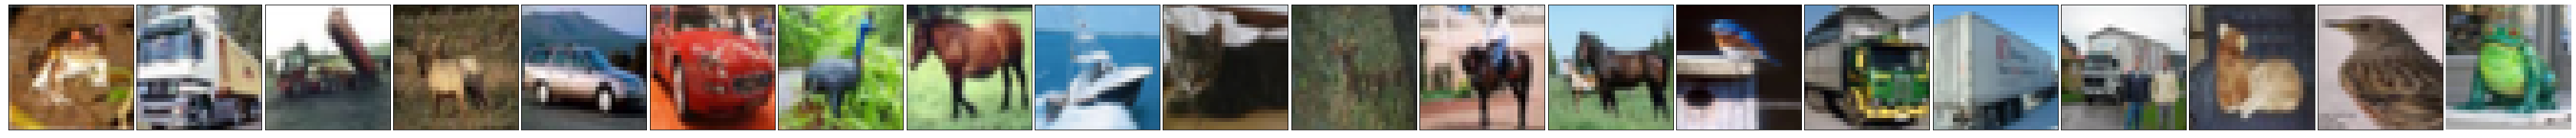

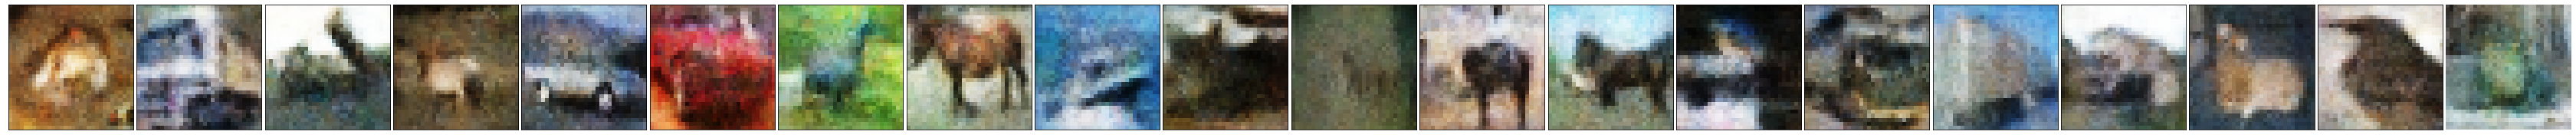

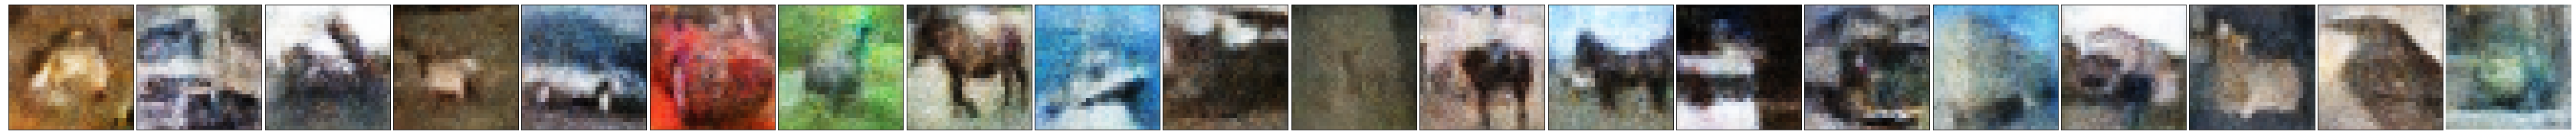

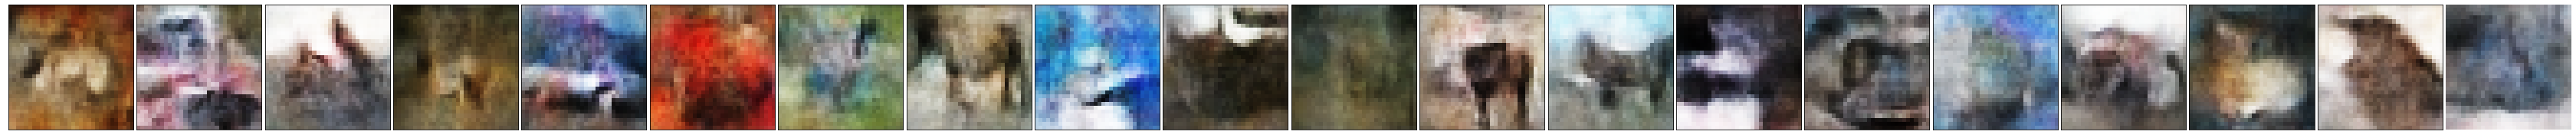

In [26]:
imgs = x_train[0:20,:,:,:]/(255.0/2.0)-1.0

imgs = image.load_cifar10(take_first=20)

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno')
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
    return fig

fig = plot(imgs)
for split in [2,3,4]:
    flattened_z = cat_dog_dsa["cat_vs_dog-split="+str(split)].f(imgs, training=False).numpy().reshape((len(imgs), cat_dog_dsa["cat_vs_dog-split="+str(split)].flattened_inter_dim))
    rec_res = cat_dog_dsa["cat_vs_dog-split="+str(split)].d(flattened_z, training=False)
    fig = plot(rec_res)

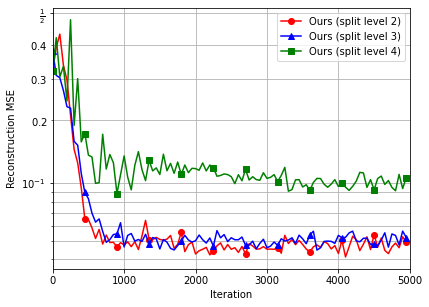

In [35]:
with open('log/cat_dog.pkl', 'rb') as f:
    log = pickle.load(f)

from matplotlib.pyplot import figure
figure(figsize=(6.4,4.8))
log_freq = 50
plt.yscale('logit')
plt.xlim([0,5000])
plt.grid("both", "both")
sampled_log_2 = [log["cat_vs_dog-split=2"][:,1][i*log_freq] for i in range(int(len(log["cat_vs_dog-split=2"][:,0])/log_freq))]
sampled_log_3 = [log["cat_vs_dog-split=3"][:,1][i*log_freq] for i in range(int(len(log["cat_vs_dog-split=3"][:,0])/log_freq))]
sampled_log_4 = [log["cat_vs_dog-split=4"][:,1][i*log_freq] for i in range(int(len(log["cat_vs_dog-split=4"][:,0])/log_freq))]
ran = [i * log_freq for i in range(int(5000/log_freq))]
plt.plot(ran, sampled_log_2, 'ro-', ran, sampled_log_3, 'b^-', ran, sampled_log_4, 'gs-', markevery=9)
plt.ylabel('Reconstruction MSE')
plt.xlabel('Iteration')
plt.legend(["Ours (split level 2)", "Ours (split level 3)", "Ours (split level 4)"])
plt.savefig("fig/cat_vs_dog-all.pdf", bbox_inches='tight')

Seems all right!